In [1]:
import os
from configs.parser import YAMLParser
import mlflow
from dataloader.h5 import H5Loader
import torch
import numpy as np
from added_codes.funcs import visualize_flow
from added_codes.classes import AEE_HIST


import matplotlib.pyplot as plt

from loss.flow import FWL, RSAT, AEE
from utils.utils import load_model
from models.model import (
    FireNet,
    RNNFireNet,
    LeakyFireNet,
    FireFlowNet,
    LeakyFireFlowNet,
    E2VID,
    EVFlowNet,
    RecEVFlowNet,
    LeakyRecEVFlowNet,
    RNNRecEVFlowNet,
)

/tudelft.net/staff-bulk/ewi/insy/VisionLab/maraghi/envs/of-b2eb2/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
runid = "EVFlowNet"

mlflow.set_tracking_uri("")
run = mlflow.get_run(runid)
config_parser = YAMLParser("configs/eval_MVSEC.yml")
config = config_parser.config
config = config_parser.merge_configs(run.data.params)


In [3]:
data = H5Loader(config, config["model"]["num_bins"])
dataloader = torch.utils.data.DataLoader(
        data,
        drop_last=True,
        batch_size=config["loader"]["batch_size"],
        collate_fn=data.custom_collate,
        worker_init_fn=config_parser.worker_init_fn
    )

In [ ]:
device = config_parser.device
# device = torch.device("cpu")
print("start loading", flush=True)
model = RecEVFlowNet(config["model"]).to(device)
print("finished loading", flush=True)
model = load_model(runid, model, device)
model.eval()

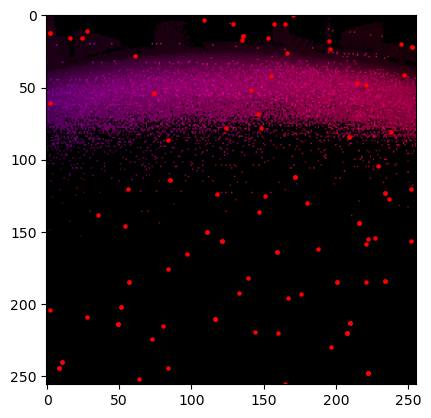

In [4]:
data_number = 0
flow = data[data_number]["gtflow"]


plt.imshow(visualize_flow(flow))
for ev in data[data_number]["event_list"].transpose(1, 0):
    plt.scatter(ev[1], ev[2], s=5, c="r")
plt.show()

In [2]:
import h5py
h5_file = h5py.File("datasets/data/MVSEC/h5/indoor_flying1_data.h5", "r")
print(h5_file.keys())


<KeysViewHDF5 ['events', 'flow', 'flow_dt1', 'flow_dt4', 'images']>


In [154]:
def event_formatting(xs, ys, ts, ps):
    """
    Reset sequence-specific variables.
    :param xs: [N] numpy array with event x location
    :param ys: [N] numpy array with event y location
    :param ts: [N] numpy array with event timestamp
    :param ps: [N] numpy array with event polarity ([-1, 1])
    :return xs: [N] tensor with event x location
    :return ys: [N] tensor with event y location
    :return ts: [N] tensor with normalized event timestamp
    :return ps: [N] tensor with event polarity ([-1, 1])
    """

    xs = torch.from_numpy(xs.astype(np.float32))
    ys = torch.from_numpy(ys.astype(np.float32))
    ts = torch.from_numpy(ts.astype(np.float32))
    ps = torch.from_numpy(ps.astype(np.float32)) * 2 - 1
    if ts.shape[0] > 0:
        ts = (ts - ts[0]) / (ts[-1] - ts[0])
    return xs, ys, ts, ps

In [3]:
def create_time_windows(timestamps, separators):
    windows = []
    start_index = 0
    
    for separator in separators:
        window = []
        
        # Find the indices of timestamps within the current window
        while start_index < len(timestamps) and timestamps[start_index] < separator:
            window.append(start_index)
            start_index += 1
        
        windows.append(window)
    
    return windows

In [4]:
%load_ext line_profiler

In [7]:
%lprun?

Docstring:
Execute a statement under the line-by-line profiler from the
line_profiler module.

Usage:
%lprun -f func1 -f func2 <statement>

The given statement (which doesn't require quote marks) is run via the
LineProfiler. Profiling is enabled for the functions specified by the -f
options. The statistics will be shown side-by-side with the code through the
pager once the statement has completed.

Options:

-f <function>: LineProfiler only profiles functions and methods it is told
to profile.  This option tells the profiler about these functions. Multiple
-f options may be used. The argument may be any expression that gives
a Python function or method object. However, one must be careful to avoid
spaces that may confuse the option parser.

-m <module>: Get all the functions/methods in a module

One or more -f or -m options are required to get any useful results.

-D <filename>: dump the raw statistics out to a pickle file on disk. The
usual extension for this is ".lprof". These statis

In [79]:
%%timeit
with h5py.File(os.path.join(mvsec_dir , file), "r") as h5_file:
    list_gt = [key[-9:] for key in h5_file[flow_type].keys()]
    timestamps_list = [h5_file[flow_type+'/flowmap'+l].attrs["timestamp"] for l in list_gt]
    timestamps_images_list = [h5_file["images/image"+l].attrs["timestamp"] for l in list_gt]
    

2.73 s ± 74.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [162]:
import importlib

# Assuming you previously imported a module called 'my_module'
import dataloader.encodings as encodings

# ...some code using 'my_module'...

# Now, if you want to reimport 'my_module', you can use the following code
importlib.reload(encodings)



import matplotlib.pyplot as plt
import tqdm

mvsec_dir = "datasets/data/MVSEC/h5/"
files = os.listdir(mvsec_dir)
flow_type = "flow_dt1" # flow_dt1

non_single_pixels_dict = dict()
file = files[3]
cc =1935 
ev_cnt_list = []
ev_voxel_list = []
image_list = []
with h5py.File(os.path.join(mvsec_dir , file), "r") as h5_file:
    list_gt = [key[-9:] for key in h5_file[flow_type].keys()]
    timestamps_list = [h5_file[flow_type+'/flowmap'+l].attrs["timestamp"] for l in list_gt]
    event_lists = create_time_windows(h5_file["events/ts"][:],timestamps_list)
    non_single_pixels = []
    for num_bins in tqdm.tqdm(range(5, 16,2)): 
        e = event_lists[cc]
        xs = h5_file["events/xs"][e]
        ys = h5_file["events/ys"][e]
        ts = h5_file["events/ts"][e]
        ps = h5_file["events/ps"][e]
        ts -= h5_file.attrs["t0"]  # sequence starting at t0 = 0

        xs, ys, ts, ps = event_formatting(xs, ys, ts, ps)

        sensor_size = h5_file["images/image"+list_gt[0]].shape
        ev_cnt = encodings.events_to_channels(xs, ys, ps, sensor_size=sensor_size)
        ev_voxel = encodings.events_to_voxel(xs, ys, ts, ps, num_bins, sensor_size=sensor_size)
        ev_cnt_list.append(ev_cnt)
        image_list.append(h5_file["images/image"+list_gt[cc]][:])
        ev_voxel_list.append(ev_voxel)     


100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


5


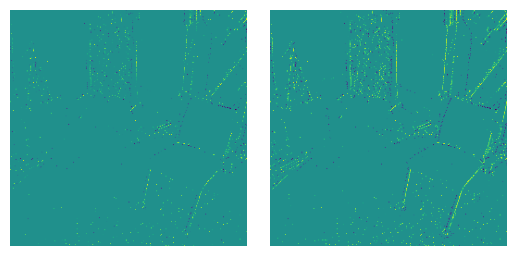

7


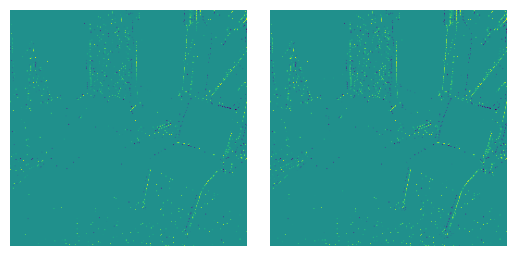

9


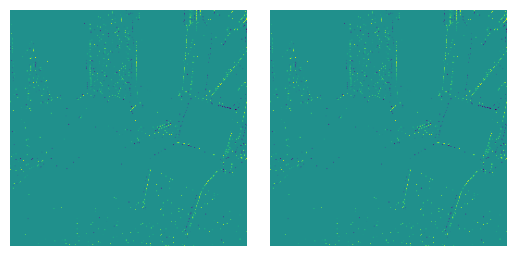

11


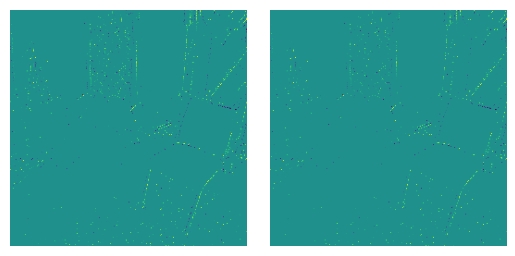

13


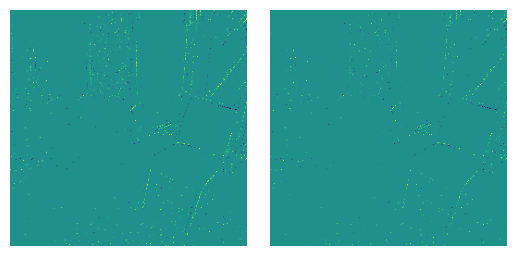

15


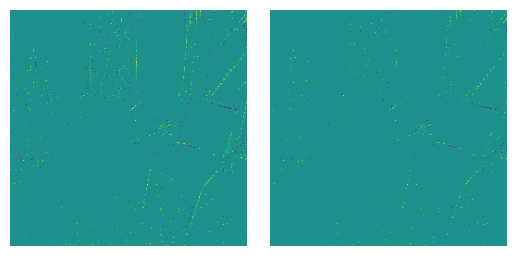

In [167]:
for cc,ev_cnt in enumerate(ev_voxel_list):
    print(5+2*cc)
    bin_middle = (ev_cnt.shape[0] -1) >> 1

    fig, axes = plt.subplots(1, 2)

    # Display the first image in the first subplot
    axes[0].imshow(ev_voxel_list[2][4,...])
    axes[0].axis('off')

    # Display the second image in the second subplot
    axes[1].imshow(ev_cnt[bin_middle,...])
    axes[1].axis('off')
    
    # axes[2].imshow(ev_cnt[-1,...])
    # axes[2].axis('off')

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the figure
    plt.show()

0


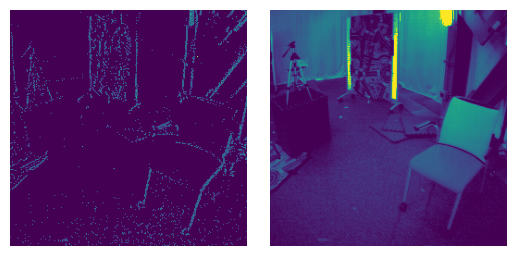

1


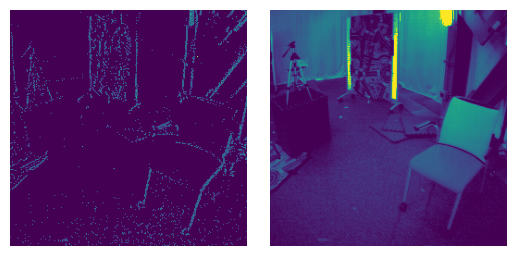

2


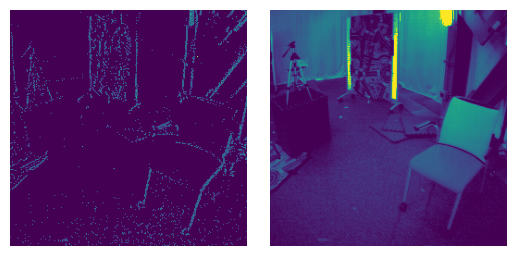

3


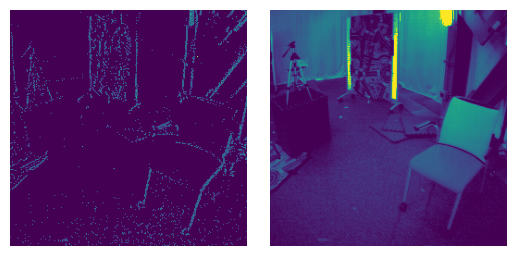

4


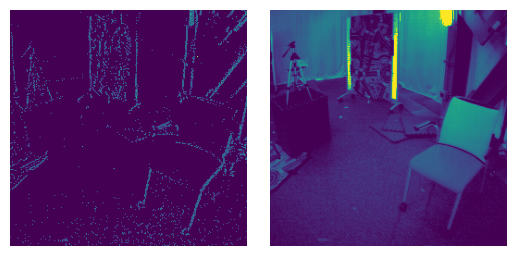

In [157]:

for cc,ev_cnt in enumerate(ev_cnt_list):
    print(cc)
    # Assuming you have two image arrays called 'image1' and 'image2'
    fig, axes = plt.subplots(1, 2)

    # Display the first image in the first subplot
    axes[0].imshow(ev_cnt_list[cc][0])
    axes[0].axis('off')

    # Display the second image in the second subplot
    axes[1].imshow(image_list[cc])
    axes[1].axis('off')

    # Adjust the spacing between the subplots
    plt.subplots_adjust(wspace=0.1)

    # Show the figure
    plt.show()

100%|██████████| 1399/1399 [01:59<00:00, 11.70it/s]


indoor_flying1_data.h5 0.012275526


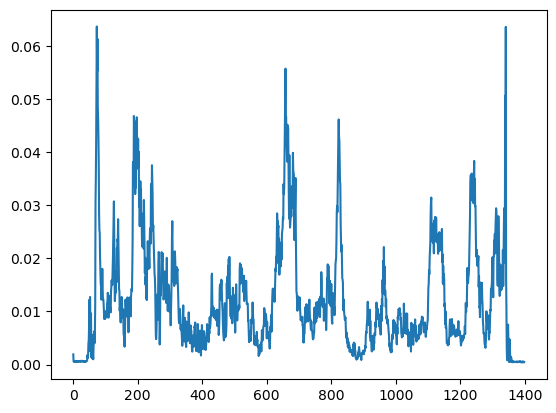

100%|██████████| 360/360 [00:48<00:00,  7.46it/s]


outdoor_day1_data.h5 0.046670403


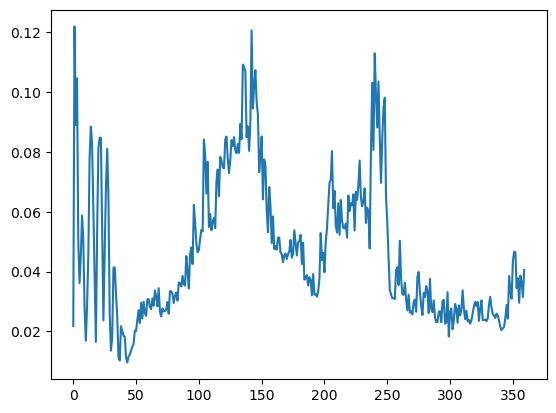

100%|██████████| 1874/1874 [02:55<00:00, 10.69it/s]


indoor_flying3_data.h5 0.019348683


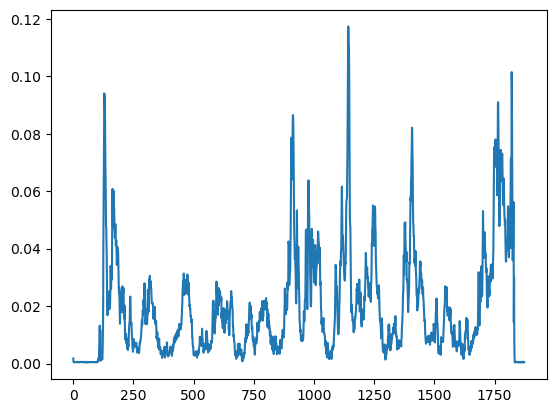

100%|██████████| 1691/1691 [03:12<00:00,  8.77it/s]


indoor_flying2_data.h5 0.023416484


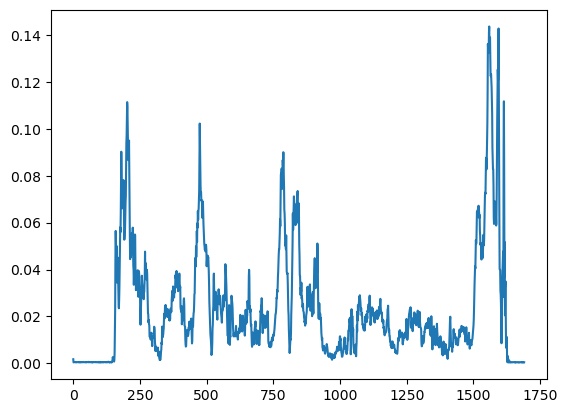

In [78]:
import dataloader.encodings as encodings
import matplotlib.pyplot as plt
import tqdm

mvsec_dir = "datasets/data/MVSEC/h5/"
files = os.listdir(mvsec_dir)
flow_type = "flow" # flow_dt1

non_single_pixels_dict = dict()
for file in files:
    h5_file = h5py.File(os.path.join(mvsec_dir , file), "r")
    list_gt = [key for key in h5_file[flow_type].keys()]
    list_image = [key for key in h5_file["images"].keys()]
    timestamps_list = [h5_file[flow_type+'/'+l].attrs["timestamp"] for l in list_gt]
    event_lists = create_time_windows(h5_file["events/ts"][:],timestamps_list)
    non_single_pixels = []
    for e in tqdm.tqdm(event_lists):
        ps = torch.ones(h5_file["events/ps"][e].shape)
        ps[~h5_file["events/ps"][e]] = -1
        ev_cnt = encodings.events_to_channels(torch.tensor(h5_file["events/xs"][e]),
                        torch.tensor(h5_file["events/ys"][e]), 
                        ps, 
                        sensor_size=h5_file["images/"+list_image[0]].shape)  
        ev_cnt_total = ev_cnt[0] + ev_cnt[1]
        non_single_pixels.append(torch.count_nonzero(ev_cnt_total>1.1)/np.prod(h5_file["images/"+list_image[0]].shape))
    non_single_pixels_dict[file] = non_single_pixels
    print(file, np.mean(non_single_pixels))
    plt.plot(non_single_pixels)
    plt.show()

In [77]:
files


['indoor_flying1_data.h5',
 'outdoor_day1_data.h5',
 'indoor_flying3_data.h5',
 'indoor_flying2_data.h5']

In [43]:
e = event_lists[0]
ps = torch.ones(h5_file["events/ps"][e].shape)
ps[~h5_file["events/ps"][e]] = -1
print(type(ps))
print(ps.dtype)
torch.any(ps > 0)

<class 'torch.Tensor'>
torch.float32


tensor(True)

In [7]:
mvsec_dir = "datasets/data/MVSEC/h5/"
os.listdir(mvsec_dir)
for file in os.listdir(mvsec_dir):
    h5_file = h5py.File(os.path.join(mvsec_dir , file), "r")
    for flow_type in h5_file.keys():
        if flow_type == "events":
            continue
        list_ = [key for key in h5_file[flow_type].keys()]
        timestamps_list = [h5_file[flow_type+'/'+l].attrs["timestamp"] for l in list_]
        event_lists = create_time_windows(h5_file["events/ts"][:],timestamps_list)
        print(file,flow_type,np.mean(np.array([len(e) for e in event_lists])))
        
        

indoor_flying1_data.h5 flow 7660.759828448892
indoor_flying1_data.h5 flow_dt1 4864.933272809805
indoor_flying1_data.h5 flow_dt4 19485.68181818182
indoor_flying1_data.h5 images 4858.427017225748
outdoor_day1_data.h5 flow 12679.677777777777
outdoor_day1_data.h5 flow_dt1 5576.952380952381
outdoor_day1_data.h5 flow_dt4 22321.323529411766
outdoor_day1_data.h5 images 5570.151219512195
indoor_flying3_data.h5 flow 9813.28068303095
indoor_flying3_data.h5 flow_dt1 6236.094269243811
indoor_flying3_data.h5 flow_dt4 24952.611940298506
indoor_flying3_data.h5 images 6229.875338753388
indoor_flying2_data.h5 flow 11500.254287403903
indoor_flying2_data.h5 flow_dt1 7305.4169797145005
indoor_flying2_data.h5 flow_dt4 29243.336842105262
indoor_flying2_data.h5 images 7297.275046904315


In [14]:
h5_file["events"]['ts'][-1] - h5_file["events"]['ts'][0]

70.28973197937012

In [5]:
for flow_type in h5_file.keys():
    if flow_type == "events":
        continue
    list_ = [key for key in h5_file[flow_type].keys()]
    timestamps_list = [h5_file[flow_type+'/'+l].attrs["timestamp"] for l in list_]
    timestamps = np.array(timestamps_list)
    print(flow_type, 1/np.mean(np.diff(timestamps)), np.mean(np.diff(timestamps)),np.std(np.diff(timestamps)))

flow 19.997165478675445 0.050007087307767636 5.831633651593308e-05
flow_dt1 31.387945034346522 0.031859365081267396 4.923732455482245e-07
flow_dt4 7.846986227182647 0.1274374608350799 5.332144190399305e-07
images 31.387945096898132 0.031859365017776316 4.924776021160936e-07


The frame rate of the optical flow ground truth is 20 fps.

And the frame rate of the (grey scale) images is about 31 fps.

The ground truth is interpolated for 'flow_dt1' in the rate of image fps, i.e. 31 fps.

The ground truth for 'flow_dt4' is 1/4 of the 'flow_dt1'.

In [ ]:
import torch
import numpy as np
import os
import cv2


class DSectDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load the list of event and image files
        self.event_files = os.listdir(os.path.join(root_dir, "events"))
        self.image_files = os.listdir(os.path.join(root_dir, "images"))

        # Sort the files to ensure they match up
        self.event_files.sort()
        self.image_files.sort()

    def __len__(self):
        return len(self.event_files)

    def __getitem__(self, idx):
        # Load the event and image files for the given index
        event_file = os.path.join(self.root_dir, "events", self.event_files[idx])
        image_file = os.path.join(self.root_dir, "images", self.image_files[idx])

        # Load the event data
        events = np.load(event_file)

        # Load the image data
        image = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)

        # Apply transformations to the data if provided
        if self.transform:
            events, image = self.transform((events, image))

        # Convert the data to PyTorch tensors
        events = torch.from_numpy(events).float()
        image = torch.from_numpy(image).float()

        return events, image

In [ ]:
# Create the dataset
dataset = DSectDataset(root_dir='/path/to/dataset')

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

# Loop over the dataloader
for events, image in dataloader:
    # Do something with the event and image data
    pass
